# RMSE and ACC plots for the CREDIT arXiv paper

In [1]:
import os
import sys
import yaml
import numpy as np
from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu

In [3]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [4]:
# graph tools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches

import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec

%matplotlib inline

## Figure settings

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

In [6]:
# colors
red0 = [1.0, 0.09803922, 0.09803922]
red1 = [1.0, 206/255, 204/255]
blue0 = [0.11372549, 0.0, 1.0]
blue1 = [218/255, 232/255, 1.0]
colors_main = [red0, blue0]
colors_sub = [red1, blue1]

line_keys = {}
line_keys['wxformer'] = {'linewidth': 3, 'linestyle': '--', 'color': colors_main[0], 'label': ''}
line_keys['IFS'] = {'linewidth': 3, 'linestyle': '-', 'color': colors_main[1], 'label': ''}

fill_keys = {}
fill_keys['wxformer'] = {'facecolor': colors_sub[0], 'alpha': 0.75, 'zorder': 1}
fill_keys['IFS'] = {'facecolor': colors_sub[1], 'alpha': 0.75, 'zorder': 1}

LEADs = np.arange(6, 240+6, 6)
LEAD_ticks = np.arange(0, 240+6, 6)[::8]

In [7]:
model_names = ['wxformer', 'IFS']
varnames_plot = ['U500', 'V500', 'T500', 'Q500', 'Z500', 't2m']
var_scales = [1.0, 1.0, 1.0, 1e4, 1e-2, 1]
var_scale_strs = ['1', '1', '1', '1E-4', '1E2', '1']

titles = ['(a) 500 hPa u-wind', 
          '(b) 500 hPa v-wind', 
          '(c) 500 hPa air temperature', 
          '(d) 500 hPa specific humidity', 
          '(e) 500 hPa geopotential height', 
          '(f) 2-m temperature']

legned_labels = ['Wxformer hourly forecasts', 'IFS 6 hourly forecasts']  
legned_labels_fill = ['95-th confidence intervals', '95-th confidence intervals']

## 2018-2020 verif

In [8]:
PLOT_data = np.load(conf['data']['save_loc'] + 'scores_CREDIT_arXiv_2024.npy', allow_pickle=True)[()]

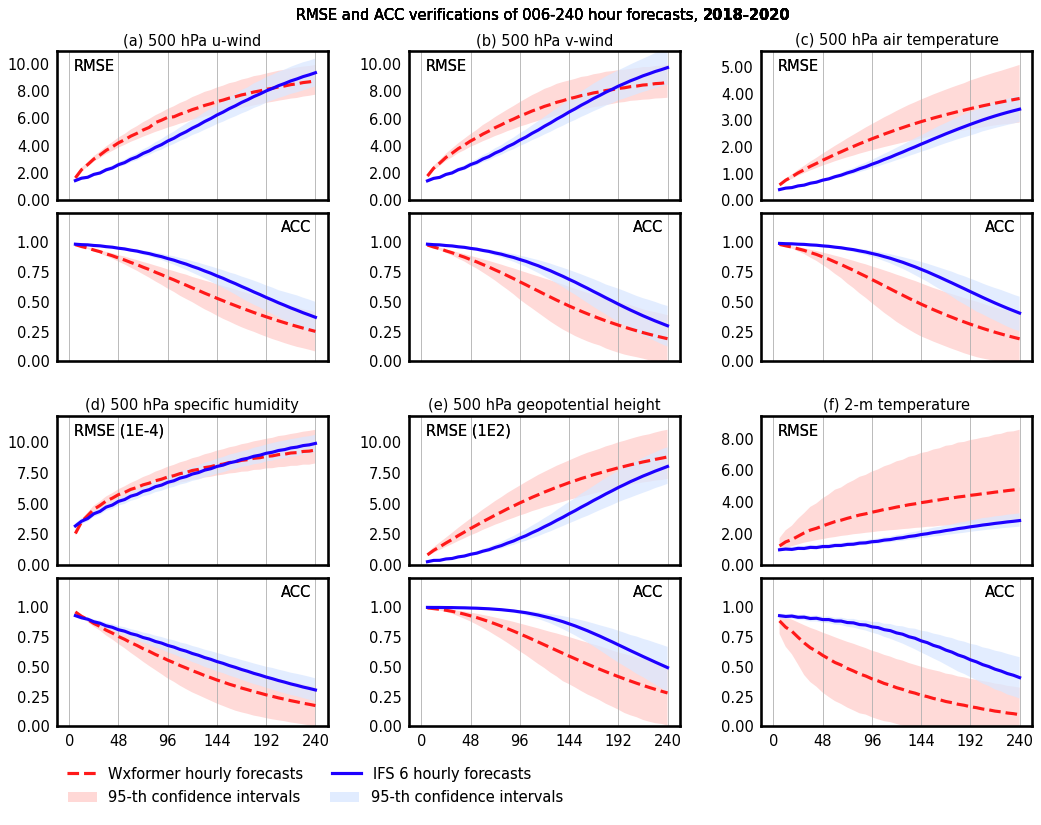

In [9]:
fig = plt.figure(figsize=(13, 9), dpi=dpi_)
gs = gridspec.GridSpec(5, 5, height_ratios=[1, 1, 0.2, 1, 1], width_ratios=[1, 0.3, 1, 0.3, 1])

handles = []

ind_x = [0, 1, 3, 4]
ind_y = [0, 2, 4]

#AX = []
AX = np.zeros((4, 3)).tolist()
AX_flat = []
for ix, ix_gs in enumerate(ind_x):
    for iy, iy_gs in enumerate(ind_y):
        AX[ix][iy] = plt.subplot(gs[ix_gs, iy_gs])
        AX_flat.append(plt.subplot(gs[ix_gs, iy_gs]))

plt.subplots_adjust(0, 0, 1, 1, hspace=0.1, wspace=0.0)

for ax in AX_flat:
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(labelleft=True)
    ax.set_xticks(LEAD_ticks)
    ax.set_xlim([LEAD_ticks[0]-12, LEAD_ticks[-1]+12])
    ax.xaxis.grid(False)
    ax.grid(':', axis='x')
    #ax.grid(':', axis='y')

for iy in range(3):
    AX[-1][iy].tick_params(labelbottom=True)
    AX[-1][iy].set_xticklabels(LEAD_ticks)

# ACC y-axis
for ix in [1, 3]:
    for iy in range(3):
        AX[ix][iy].set_ylim([0.0, 1.25])
        AX[ix][iy].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])

# RMSE y-axis
for ix in [0, 2]:
    for iy in range(3):
        AX[ix][iy].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        #AX[ix][iy].ticklabel_format(axis='y', scilimits=[0, 0])
        AX[ix][iy].locator_params(axis='y', nbins=6)
        
        
for iy, var in enumerate(varnames_plot):
    for i_model, model_name in enumerate(model_names):

        # ====================================== #
        # panel indexing
        iy_ax = iy
        ix_ax = 0 # select top 3 or bottom 3
        if iy > 2:
            iy_ax = iy_ax - 3
            ix_ax = 2
            
        # --------------------------------------------------------------------------- #
        # RMSE
        
        f = var_scales[iy] # get the scale to plot
        
        AX[0+ix_ax][iy_ax].plot(LEADs, 
                                f*PLOT_data['RMSE_{}_{}_mean'.format(model_name, var)], 
                                **line_keys[model_name])

        # # 95th CIs
        AX[0+ix_ax][iy_ax].fill_between(LEADs, 
                                        f*PLOT_data['RMSE_{}_{}_95p'.format(model_name, var)],
                                        f*PLOT_data['RMSE_{}_{}_05p'.format(model_name, var)],
                                        **fill_keys[model_name])
        
        if f == 1:
            AX[0+ix_ax][iy_ax].text(0.0625, 0.95, 'RMSE', ha='left', va='top', 
                                    fontsize=14, transform=AX[0+ix_ax][iy_ax].transAxes)
        else:
            AX[0+ix_ax][iy_ax].text(0.0625, 0.95, 'RMSE ({})'.format(var_scale_strs[iy]), ha='left', va='top', 
                                    fontsize=14, transform=AX[0+ix_ax][iy_ax].transAxes)
        
        # # set ylim here to match the max RMSE vals
        if i_model == 0:
            AX[0+ix_ax][iy_ax].set_ylim([0, 1.1*np.max(f*PLOT_data['RMSE_{}_{}_95p'.format(model_name, var)])])

        # --------------------------------------------------------------------------- #
        # ACC
        AX[1+ix_ax][iy_ax].plot(LEADs, 
                                PLOT_data['ACC_{}_{}_mean'.format(model_name, var)], 
                                **line_keys[model_name])

        AX[1+ix_ax][iy_ax].fill_between(LEADs, 
                                        PLOT_data['ACC_{}_{}_95p'.format(model_name, var)],
                                        PLOT_data['ACC_{}_{}_05p'.format(model_name, var)],
                                        **fill_keys[model_name])
        
        AX[1+ix_ax][iy_ax].text(0.9375, 0.95, 'ACC', ha='right', va='top', 
                                fontsize=14, transform=AX[1+ix_ax][iy_ax].transAxes)

        # title
        AX[0+ix_ax][iy_ax].set_title(titles[iy], fontsize=14)

    handle_legneds1 = []
    handle_legneds1.append(mlines.Line2D([], [], **line_keys['wxformer']))
    handle_legneds1.append(mlines.Line2D([], [], **line_keys['IFS']))
    
    ax_lg1 = fig.add_axes([0.0, -0.1, 0.5, 0.06])
    LG1 = ax_lg1.legend(handle_legneds1, legned_labels, 
                        bbox_to_anchor=(1, 1), ncol=2, prop={'size':14})
    LG1 = gu.lg_box(LG1)


    handle_legneds2 = []
    handle_legneds2.append(patches.Patch(**fill_keys['wxformer']))
    handle_legneds2.append(patches.Patch(**fill_keys['IFS']))
    
    ax_lg2 = fig.add_axes([0.0, -0.135, 0.5325, 0.06])
    LG2 = ax_lg2.legend(handle_legneds2, legned_labels_fill, 
                        bbox_to_anchor=(1, 1), ncol=2, prop={'size':14})
    LG2 = gu.lg_box(LG2)
    
    ax_title1 = fig.add_axes([0.0, 1.025, 1.0, 0.04])
    title_len = 0.51
    fontsize_list = [14,]*10
    fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal', 'bold', 'normal']
    handles += gu.string_partial_format(fig, ax_title1, 0.5*(1-title_len), 1.0, 'left', 'top', 
                                        ['RMSE and ACC verifications of 006-240 hour forecasts, ',
                                         '2018-2020',], 
                                        ['k', 'k'], 
                                        fontsize_list, fontweight_list)
    
    ax_lg1.set_axis_off()
    ax_lg2.set_axis_off()
    ax_title1.set_axis_off()

if need_publish:
    # Save figure
    fig.savefig(conf['figure']['save_loc']+'CREDIT_arXiv_fig1.png', format='png', **conf['figure']['keys'])

## Verif separate by years

In [10]:
PLOT_data = np.load(
    '/glade/derecho/scratch/ksha/CREDIT/verif/PLOT_data/scores_CREDIT_arXiv_2024_by_year.npy', 
    allow_pickle=True)[()]

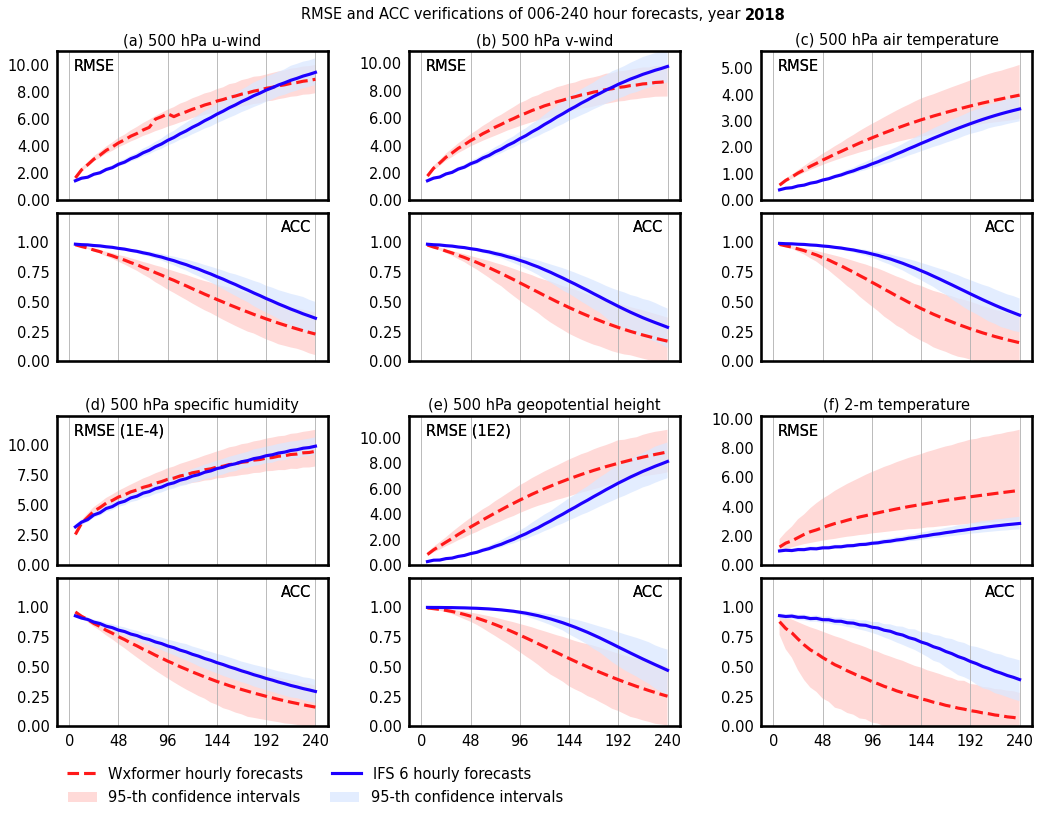

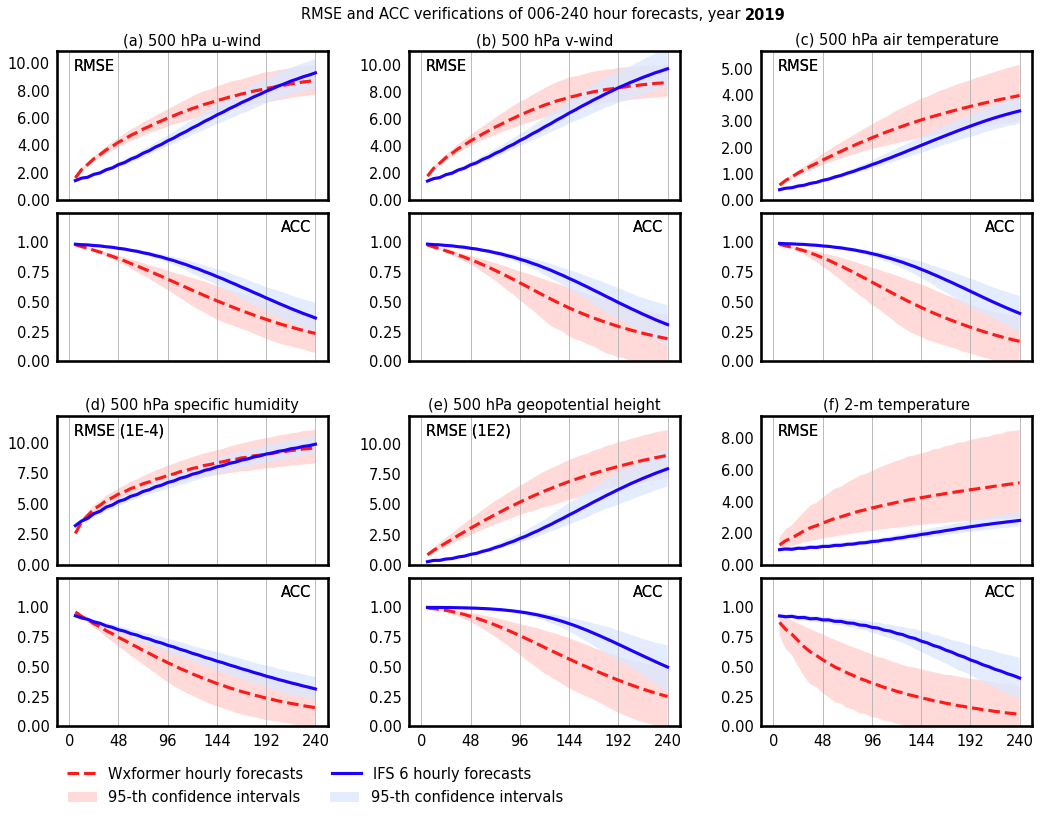

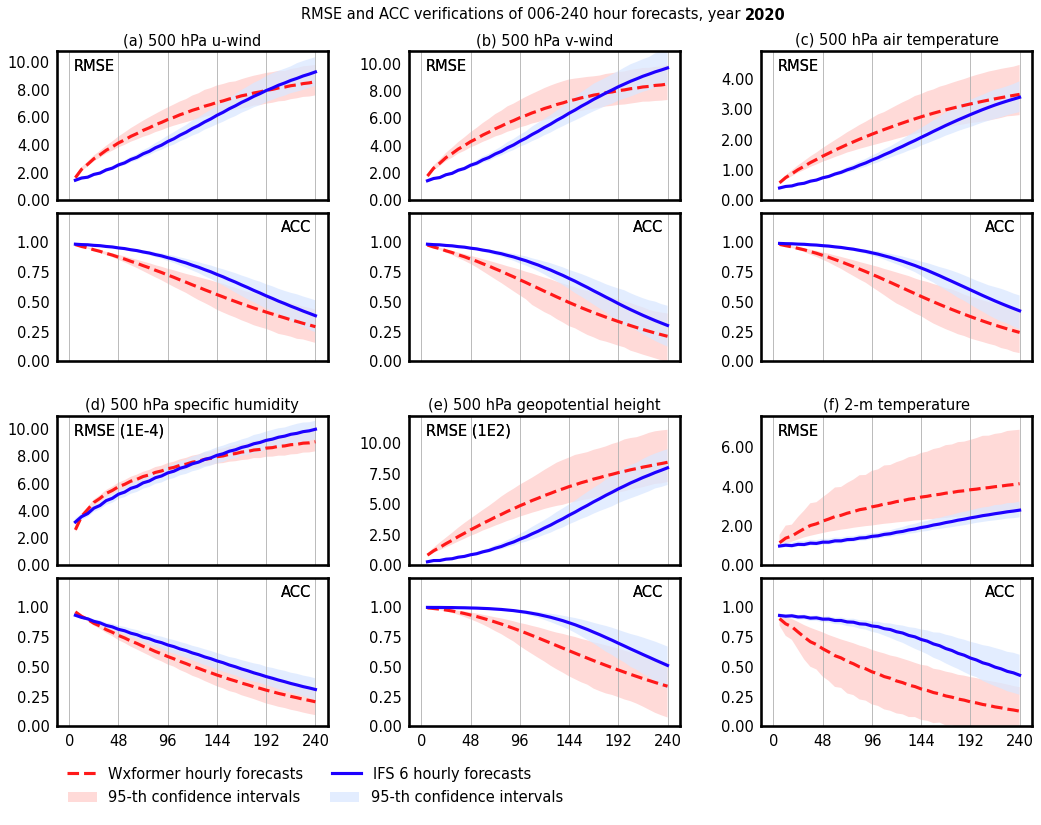

In [11]:
for i_year, year in enumerate([2018, 2019, 2020]):
    
    fig = plt.figure(figsize=(13, 9), dpi=dpi_)
    gs = gridspec.GridSpec(5, 5, height_ratios=[1, 1, 0.2, 1, 1], width_ratios=[1, 0.3, 1, 0.3, 1])
    
    handles = []
    
    ind_x = [0, 1, 3, 4]
    ind_y = [0, 2, 4]
    
    #AX = []
    AX = np.zeros((4, 3)).tolist()
    AX_flat = []
    for ix, ix_gs in enumerate(ind_x):
        for iy, iy_gs in enumerate(ind_y):
            AX[ix][iy] = plt.subplot(gs[ix_gs, iy_gs])
            AX_flat.append(plt.subplot(gs[ix_gs, iy_gs]))
    
    plt.subplots_adjust(0, 0, 1, 1, hspace=0.1, wspace=0.0)
    
    for ax in AX_flat:
        ax = gu.ax_decorate_box(ax)
        ax.tick_params(labelleft=True)
        ax.set_xticks(LEAD_ticks)
        ax.set_xlim([LEAD_ticks[0]-12, LEAD_ticks[-1]+12])
        ax.xaxis.grid(False)
        ax.grid(':', axis='x')
        #ax.grid(':', axis='y')
    
    for iy in range(3):
        AX[-1][iy].tick_params(labelbottom=True)
        AX[-1][iy].set_xticklabels(LEAD_ticks)
    
    # ACC y-axis
    for ix in [1, 3]:
        for iy in range(3):
            AX[ix][iy].set_ylim([0.0, 1.25])
            AX[ix][iy].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    
    # RMSE y-axis
    for ix in [0, 2]:
        for iy in range(3):
            AX[ix][iy].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
            #AX[ix][iy].ticklabel_format(axis='y', scilimits=[0, 0])
            AX[ix][iy].locator_params(axis='y', nbins=6)
            
            
    for iy, var in enumerate(varnames_plot):
        for i_model, model_name in enumerate(model_names):
    
            # ====================================== #
            # panel indexing
            iy_ax = iy
            ix_ax = 0 # select top 3 or bottom 3
            if iy > 2:
                iy_ax = iy_ax - 3
                ix_ax = 2
                
            # --------------------------------------------------------------------------- #
            # RMSE
            
            f = var_scales[iy] # get the scale to plot
            
            AX[0+ix_ax][iy_ax].plot(LEADs, 
                                    f*PLOT_data['RMSE_{}_{}_{}_mean'.format(model_name, var, year)], 
                                    **line_keys[model_name])
    
            # # 95th CIs
            AX[0+ix_ax][iy_ax].fill_between(LEADs, 
                                            f*PLOT_data['RMSE_{}_{}_{}_95p'.format(model_name, var, year)],
                                            f*PLOT_data['RMSE_{}_{}_{}_05p'.format(model_name, var, year)],
                                            **fill_keys[model_name])
            
            if f == 1:
                AX[0+ix_ax][iy_ax].text(0.0625, 0.95, 'RMSE', ha='left', va='top', 
                                        fontsize=14, transform=AX[0+ix_ax][iy_ax].transAxes)
            else:
                AX[0+ix_ax][iy_ax].text(0.0625, 0.95, 'RMSE ({})'.format(var_scale_strs[iy]), ha='left', va='top', 
                                        fontsize=14, transform=AX[0+ix_ax][iy_ax].transAxes)
            
            # # set ylim here to match the max RMSE vals
            if i_model == 0:
                AX[0+ix_ax][iy_ax].set_ylim([0, 
                                             1.1*np.max(f*PLOT_data['RMSE_{}_{}_{}_95p'.format(
                                                 model_name, var, year)])])
    
            # --------------------------------------------------------------------------- #
            # ACC
            AX[1+ix_ax][iy_ax].plot(LEADs, 
                                    PLOT_data['ACC_{}_{}_{}_mean'.format(model_name, var, year)], 
                                    **line_keys[model_name])
    
            AX[1+ix_ax][iy_ax].fill_between(LEADs, 
                                            PLOT_data['ACC_{}_{}_{}_95p'.format(model_name, var, year)],
                                            PLOT_data['ACC_{}_{}_{}_05p'.format(model_name, var, year)],
                                            **fill_keys[model_name])
            
            AX[1+ix_ax][iy_ax].text(0.9375, 0.95, 'ACC', ha='right', va='top', 
                                    fontsize=14, transform=AX[1+ix_ax][iy_ax].transAxes)
    
            # title
            AX[0+ix_ax][iy_ax].set_title(titles[iy], fontsize=14)
    
    handle_legneds1 = []
    handle_legneds1.append(mlines.Line2D([], [], **line_keys['wxformer']))
    handle_legneds1.append(mlines.Line2D([], [], **line_keys['IFS']))
    
    ax_lg1 = fig.add_axes([0.0, -0.1, 0.5, 0.06])
    LG1 = ax_lg1.legend(handle_legneds1, legned_labels, 
                        bbox_to_anchor=(1, 1), ncol=2, prop={'size':14})
    LG1 = gu.lg_box(LG1)


    handle_legneds2 = []
    handle_legneds2.append(patches.Patch(**fill_keys['wxformer']))
    handle_legneds2.append(patches.Patch(**fill_keys['IFS']))
    
    ax_lg2 = fig.add_axes([0.0, -0.135, 0.5325, 0.06])
    LG2 = ax_lg2.legend(handle_legneds2, legned_labels_fill, 
                        bbox_to_anchor=(1, 1), ncol=2, prop={'size':14})
    LG2 = gu.lg_box(LG2)
    
    ax_title1 = fig.add_axes([0.0, 1.025, 1.0, 0.04])
    title_len = 0.5
    fontsize_list = [14,]*10
    fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal', 'bold', 'normal']
    handles += gu.string_partial_format(fig, ax_title1, 0.5*(1-title_len), 1.0, 'left', 'top', 
                                        ['RMSE and ACC verifications of 006-240 hour forecasts, year ',
                                         '{}'.format(year),], 
                                        ['k', 'k'], 
                                        fontsize_list, fontweight_list)
    
    ax_lg1.set_axis_off()
    ax_lg2.set_axis_off()
    ax_title1.set_axis_off()
    
    if need_publish:
        # Save figure
        fig.savefig(conf['figure']['save_loc']+'CREDIT_arXiv_yearly_fig{}.png'.format(i_year), 
                    format='png', **conf['figure']['keys'])